In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
from scipy import stats
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
sys_name = {"perf_dynam": "Dynamically Linked", "perf_static": "Statically Linked", "power_cores_dynam": "Dynamically Linked", "power_cores_static": "Statically Linked", "power_mem_dynam": "Dynamically Linked", "power_mem_static": "Statically Linked"}

In [2]:
def clean_file(file_name):
    with open(file_name, 'r') as fin:
        data = fin.read().splitlines(True)
    with open(file_name, 'w') as fout:
        fout.writelines(data[3:])

In [3]:
def load_file(data_set,f_name, run_number):
    file_name = "{}_data/{}/{}.data".format(data_set,run_number,f_name)
    with open(file_name, 'r') as file:
        x = file.read().splitlines(True)
        if x[0] == "\n":
            clean_file(file_name)
        file.seek(0)
        data = file.read().split("\n")
        file.close()
        for i in range(len(data)):
            data[i] = ' '.join(data[i].split())
        data = '\n'.join(data)
        data = re.split("#|\n", data)
        while ("" in data):
            data.remove("")
        for i in range(len(data)):
            x = re.match("(\d+([,\.]*\d*)*)(.*)",data[i].strip())
            data[i] = [x.groups()[2].strip(), x.groups()[0]]
        d = dict(data)
        for key in d.keys():
            d[key] = [float(d[key].replace(",",""))]
        system = sys_name[f_name]
        if "sym" in data_set:
            system = system + " Symbiote"
        if "shortcut" in data_set:
            system = system + " Shortcutted"
        if "interpose" in data_set:
            system = system + " Interposed"
        d["sys"]=[system]
    return d

In [4]:
def load_data(data_set,data_name, total_runs):
    data = load_file(data_set,data_name,1)
    for idx in range(2,total_runs+1):
        run_data = load_file(data_set,data_name, idx)
        for key in run_data.keys():
            data[key].append(run_data[key][0])
    
    return pd.DataFrame.from_dict(data)

In [5]:
def calc_diff(higher, lower):
    sc = lower.copy()
    diff = higher.copy()
    diff.drop('System', axis=1, inplace=True)
    sc.drop('System', axis=1, inplace=True)
    
    diff.loc[:,'Latency':] = diff.loc[:,'Latency':].subtract(sc.loc[:,'Latency':])
    diff = diff.mask(diff < 0, 0)
    diff.loc[:,'Latency':] = diff.loc[:,'Latency':].div(higher.loc[:,'Latency':]).mul(100)
    diff.rename(columns={'Latency':'Improvement'}, inplace=True)
    return diff

In [6]:
num_runs = 20
dynam_data = load_data('static_v_dynam','perf_dynam', num_runs)
static_data = load_data('static_v_dynam','perf_static', num_runs)
dynam_cores_data = load_data('static_v_dynam','power_cores_dynam', num_runs)
static_cores_data = load_data('static_v_dynam','power_cores_static', num_runs)
dynam_mem_data = load_data('static_v_dynam','power_mem_dynam', num_runs)
static_mem_data = load_data('static_v_dynam','power_mem_static', num_runs)

dynam_sym_data = load_data('static_v_dynam_sym','perf_dynam', num_runs)
static_sym_data = load_data('static_v_dynam_sym','perf_static', num_runs)
dynam_sym_cores_data = load_data('static_v_dynam_sym','power_cores_dynam', num_runs)
static_sym_cores_data = load_data('static_v_dynam_sym','power_cores_static', num_runs)
dynam_sym_mem_data = load_data('static_v_dynam_sym','power_mem_dynam', num_runs)
static_sym_mem_data = load_data('static_v_dynam_sym','power_mem_static', num_runs)

shortcut_data = load_data('shortcut','perf_dynam', num_runs)
shortcut_cores_data = load_data('shortcut','power_cores_dynam', num_runs)
shortcut_mem_data = load_data('shortcut','power_mem_dynam', num_runs)

interpose_data = load_data('interpose','perf_dynam', num_runs)
interpose_cores_data = load_data('interpose','power_cores_dynam', num_runs)
interpose_mem_data = load_data('interpose','power_mem_dynam', num_runs)

svd_data = pd.concat([dynam_data, static_data], ignore_index=True)
svd_cores_data = pd.concat([dynam_cores_data, static_cores_data], ignore_index=True)
svd_mem_data = pd.concat([dynam_mem_data, static_mem_data], ignore_index=True)

svd_sym_data = pd.concat([dynam_sym_data, static_sym_data, shortcut_data, interpose_data], ignore_index=True)
svd_sym_cores_data = pd.concat([dynam_sym_cores_data, static_sym_cores_data, shortcut_cores_data, interpose_cores_data], ignore_index=True)
svd_sym_mem_data = pd.concat([dynam_sym_mem_data, static_sym_mem_data, shortcut_mem_data, interpose_mem_data], ignore_index=True)

svd_data_all = pd.concat([svd_data, svd_sym_data], ignore_index=True)
svd_cores_data_all = pd.concat([svd_cores_data, svd_sym_cores_data], ignore_index=True)
svd_mem_data_all = pd.concat([svd_mem_data, svd_sym_mem_data], ignore_index=True)

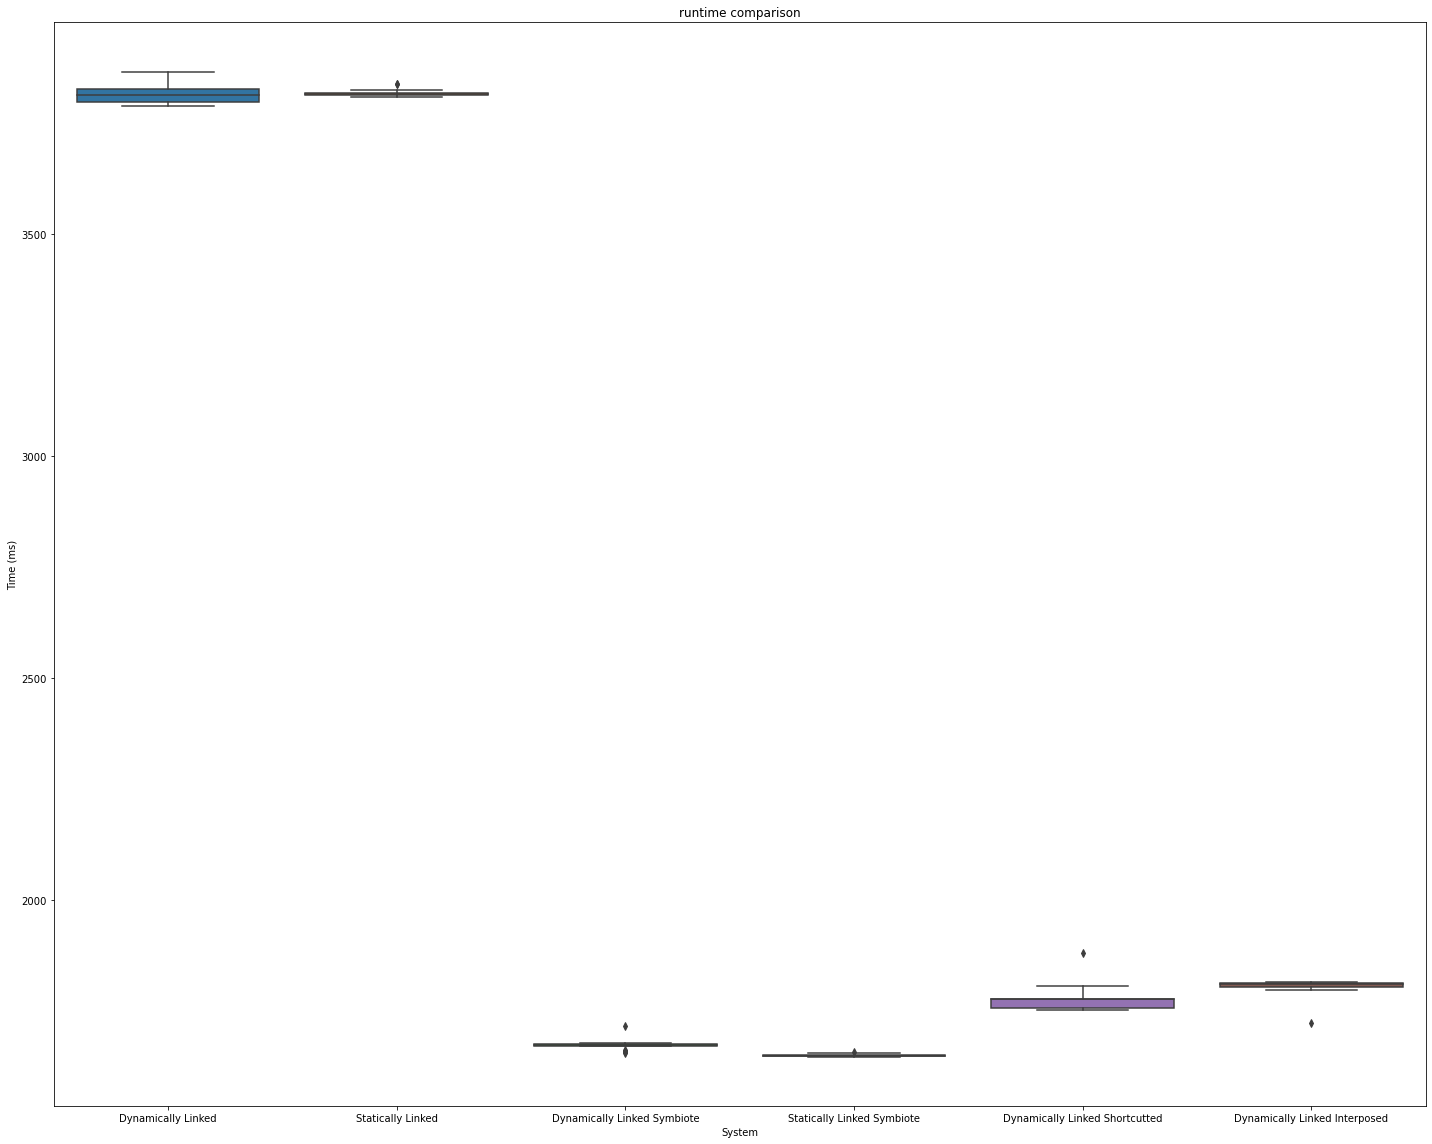

In [15]:
fig = sns.boxplot(y='msec task-clock', x='sys', data=svd_data_all)
fig.set(title="runtime comparison")
plt.xlabel('System')
plt.ylabel('Time (ms)')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 16]
plt.savefig('graphs/runtime.png')

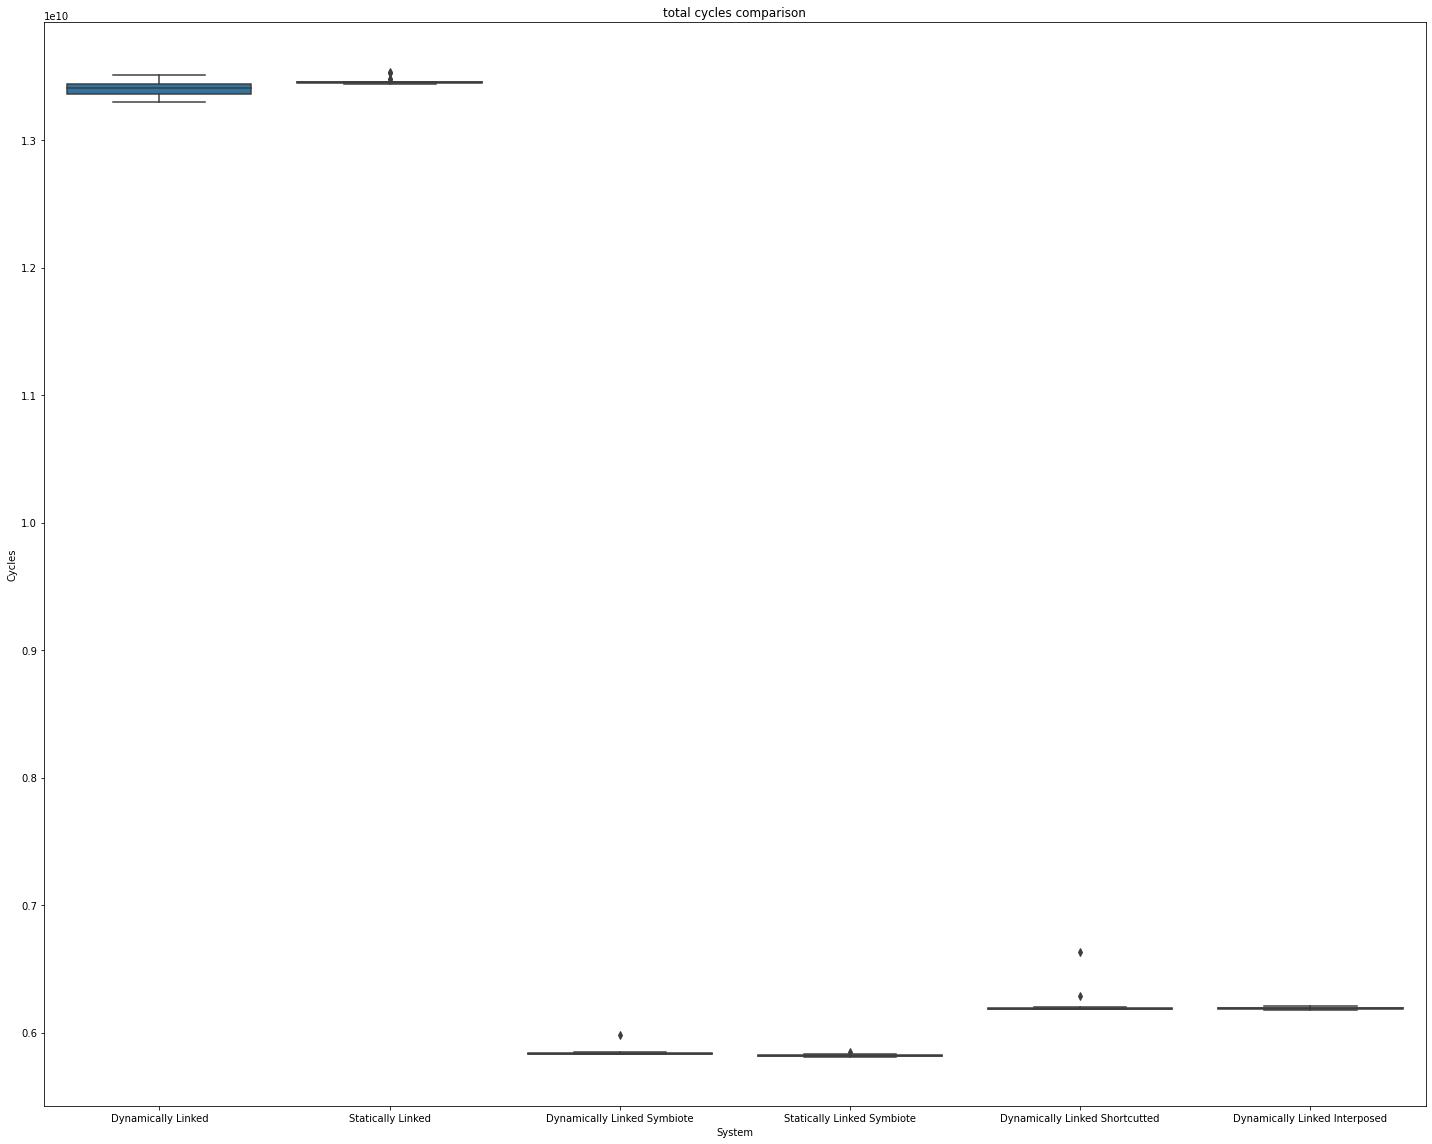

In [8]:
fig = sns.boxplot(y='cycles', x='sys', data=svd_data_all)
fig.set(title="total cycles comparison")
plt.xlabel('System')
plt.ylabel('Cycles')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 16]
plt.savefig('graphs/cycles.png')

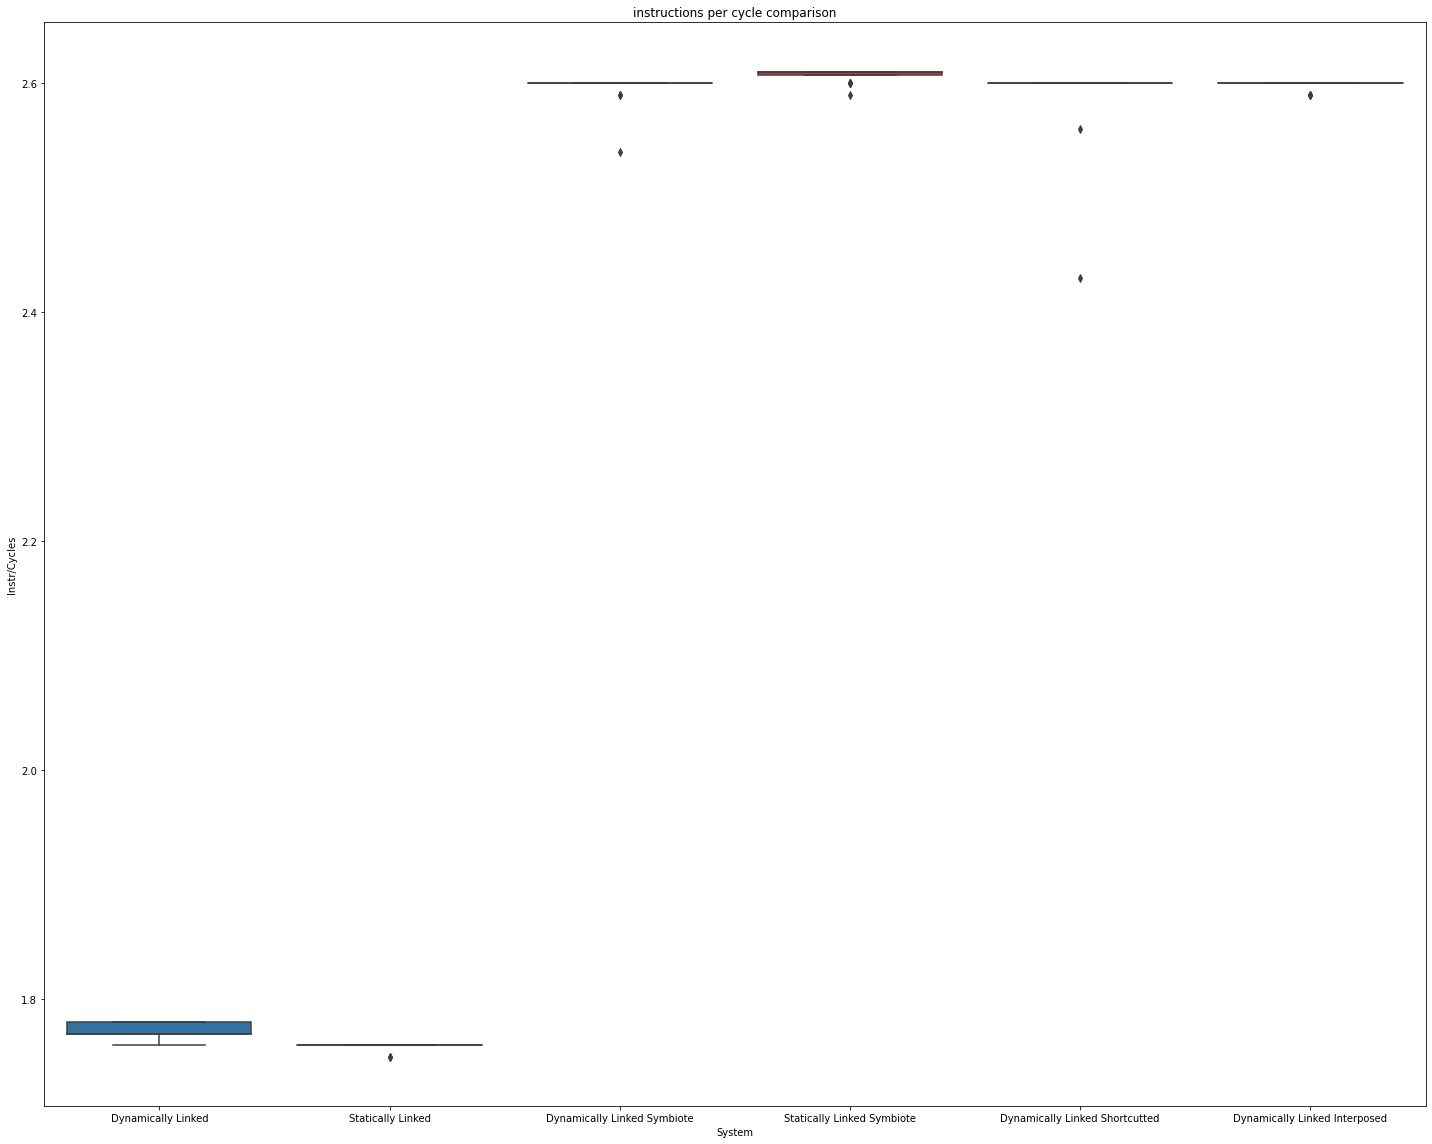

In [9]:
fig = sns.boxplot(y='insn per cycle', x='sys', data=svd_data_all)
fig.set(title="instructions per cycle comparison")
plt.xlabel('System')
plt.ylabel('Instr/Cycles')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 16]
plt.savefig('graphs/ipc.png')

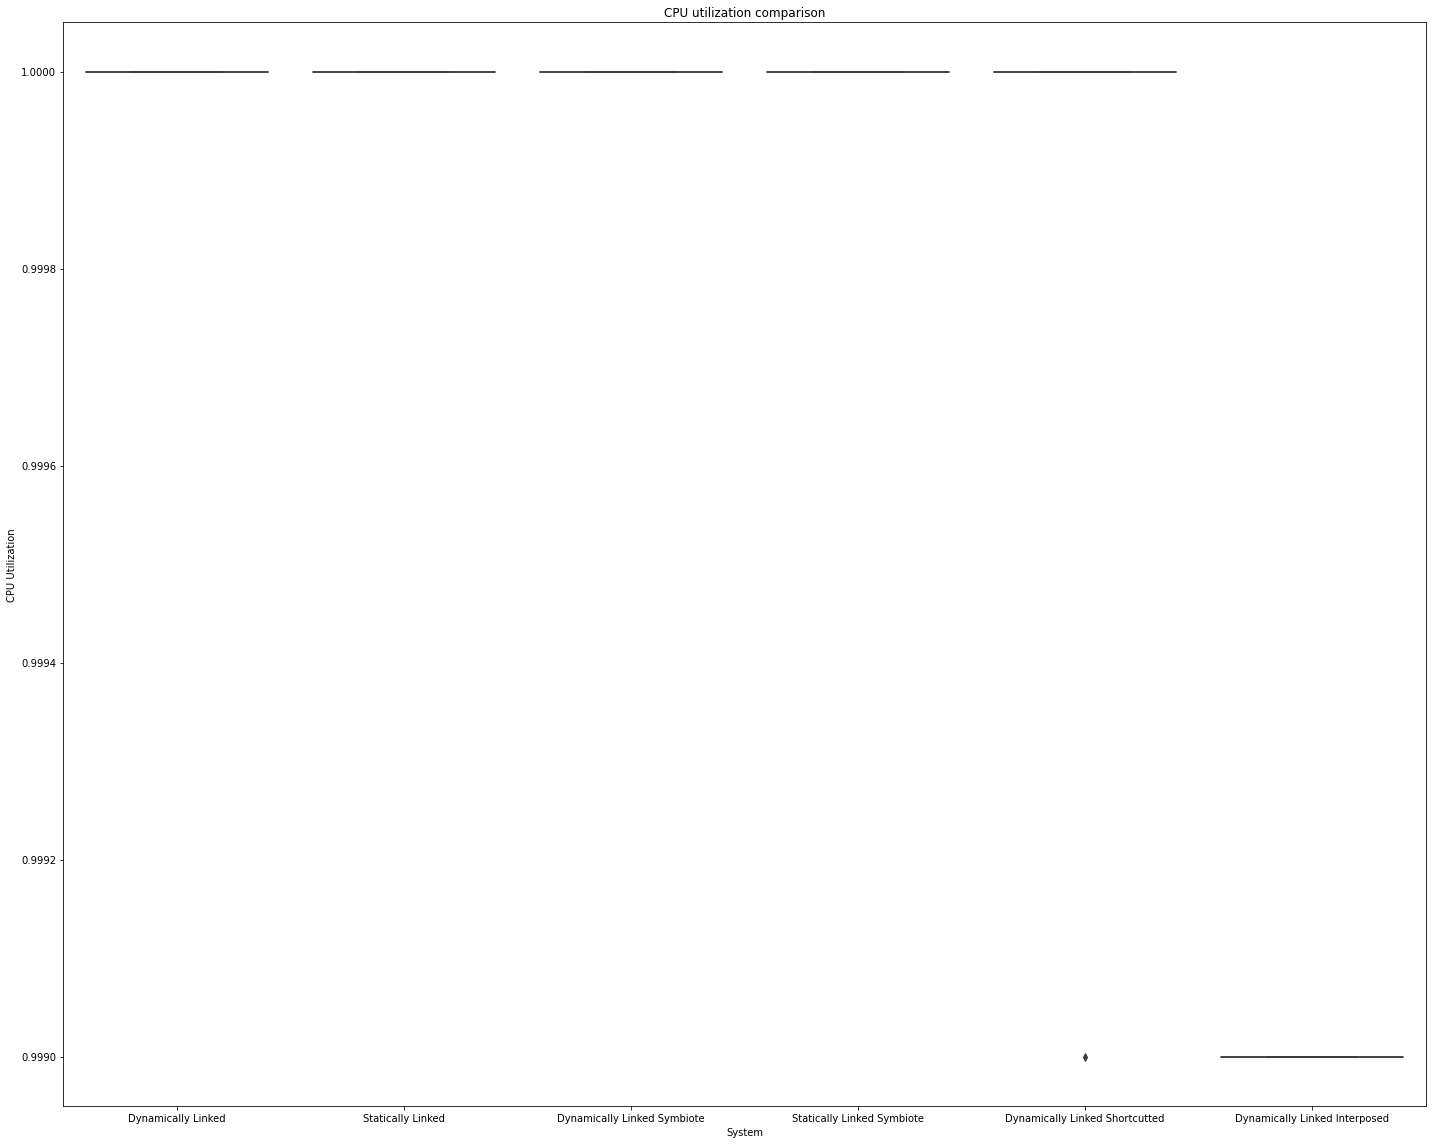

In [10]:
fig = sns.boxplot(y='CPUs utilized', x='sys', data=svd_data_all)
fig.set(title="CPU utilization comparison")
plt.xlabel('System')
plt.ylabel('CPU Utilization')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 16]
plt.savefig('graphs/utilization.png')

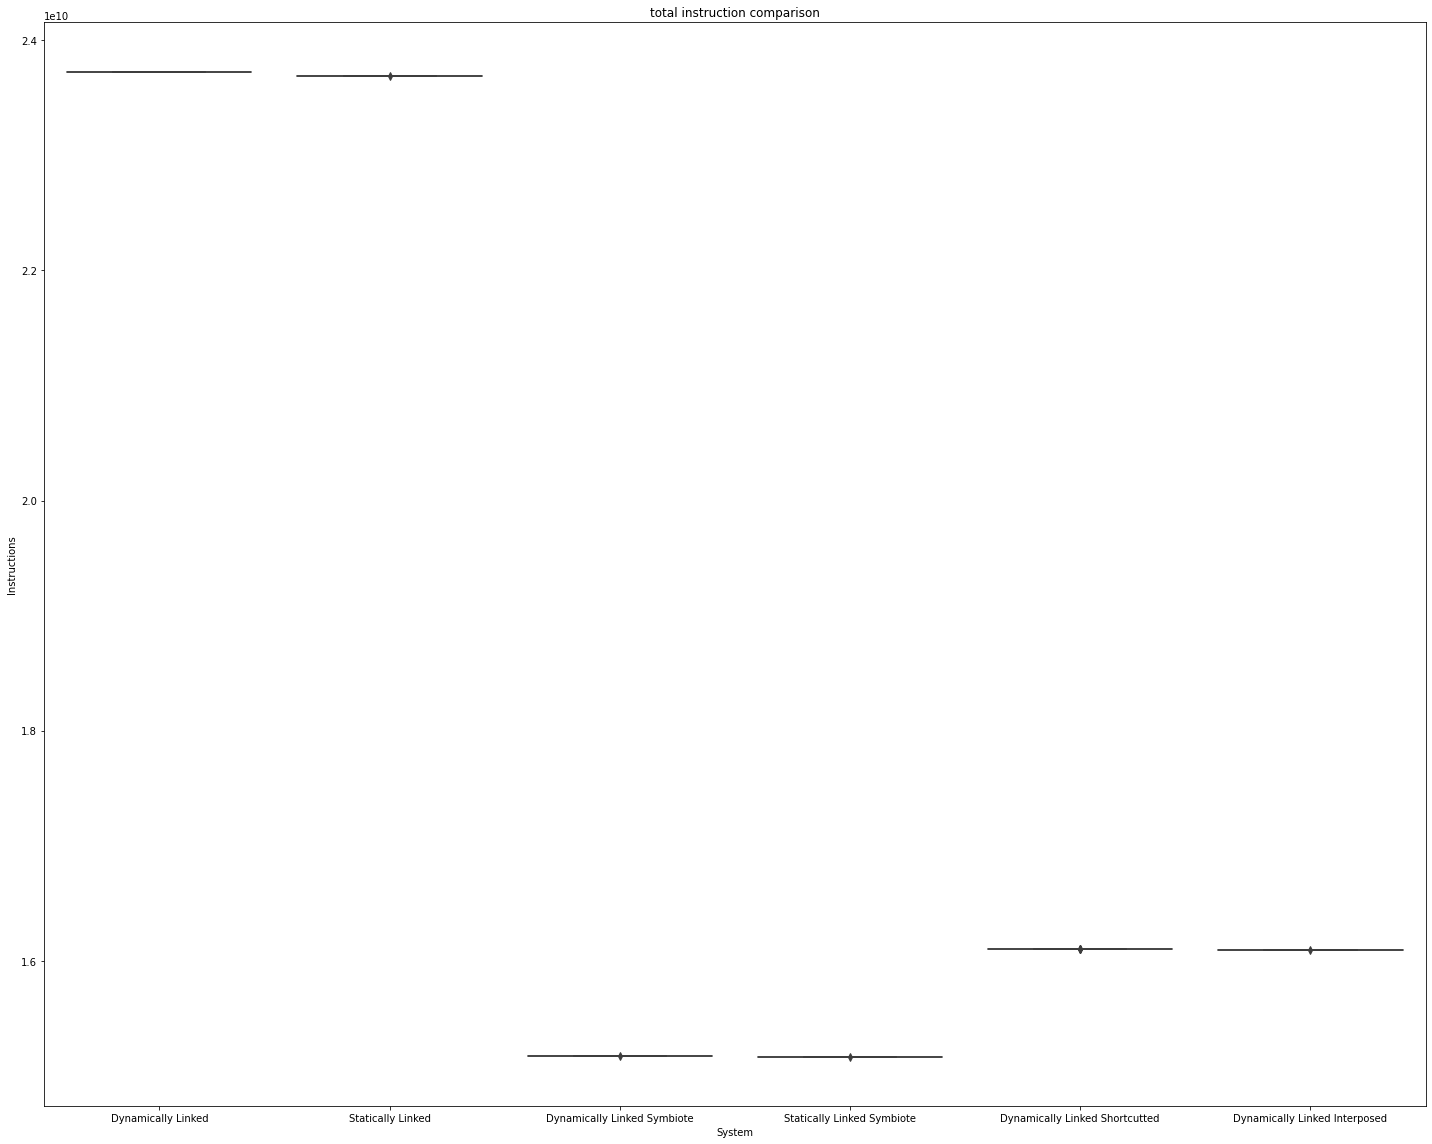

In [11]:
fig = sns.boxplot(y='instructions', x='sys', data=svd_data_all)
fig.set(title="total instruction comparison")
plt.xlabel('System')
plt.ylabel('Instructions')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 16]
plt.savefig('graphs/instructions.png')

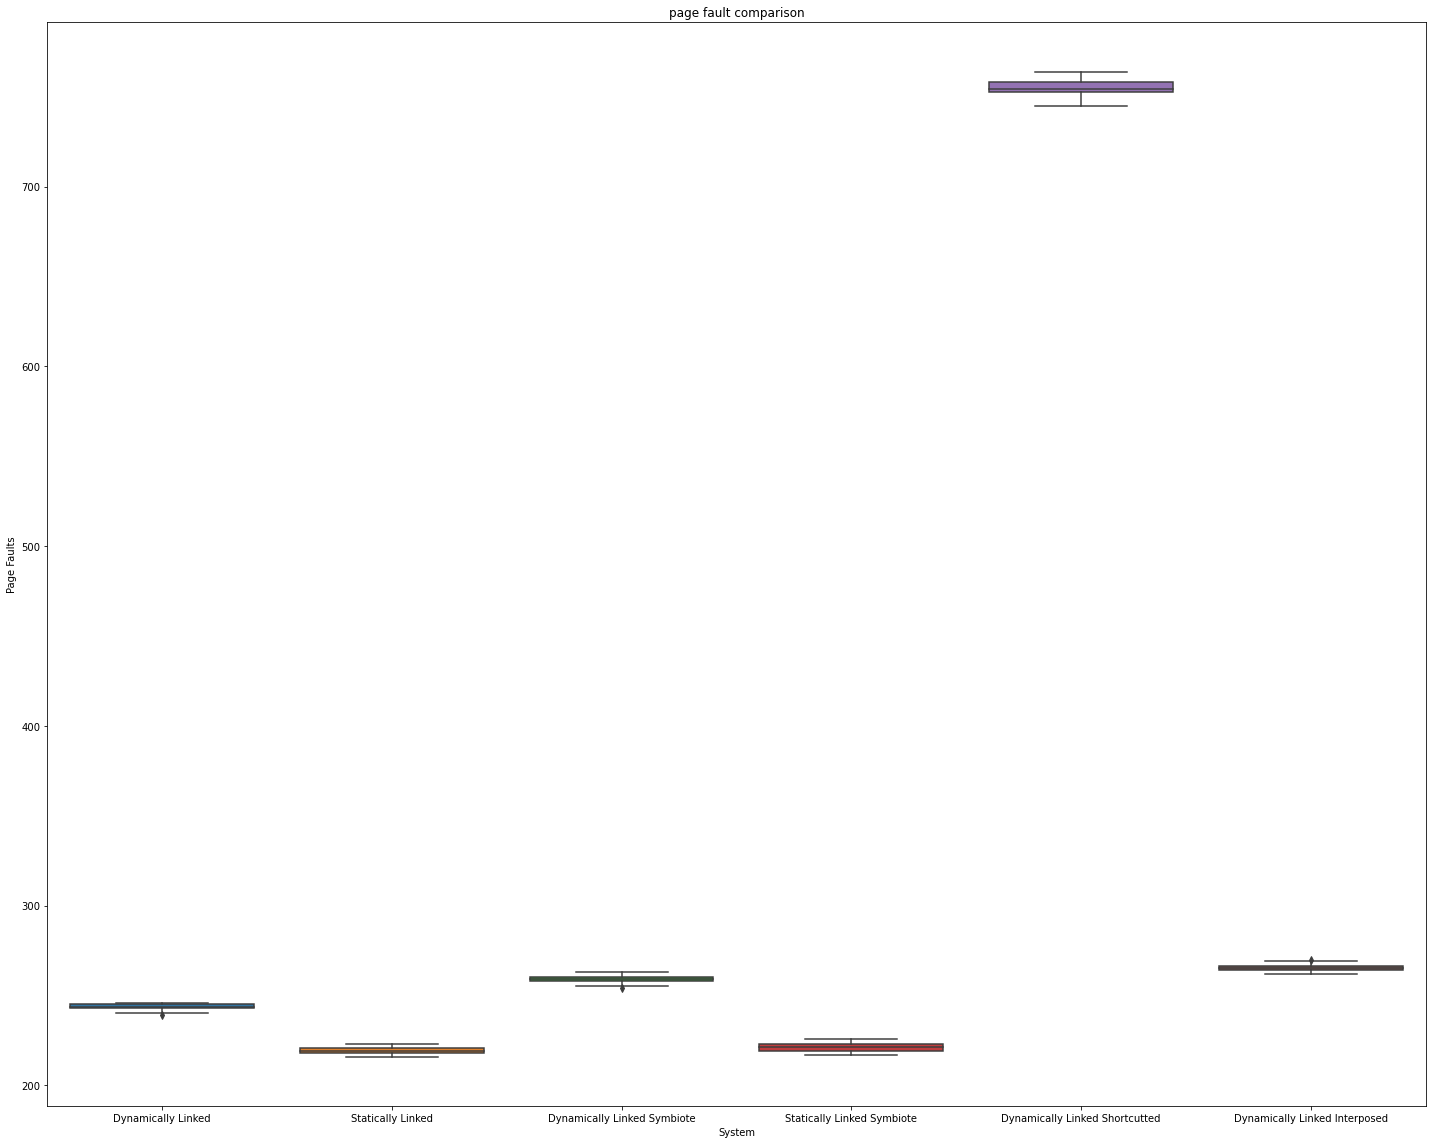

In [12]:
fig = sns.boxplot(y='page-faults', x='sys', data=svd_data_all)
fig.set(title="page fault comparison")
plt.xlabel('System')
plt.ylabel('Page Faults')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 16]
plt.savefig('graphs/page-faults.png')

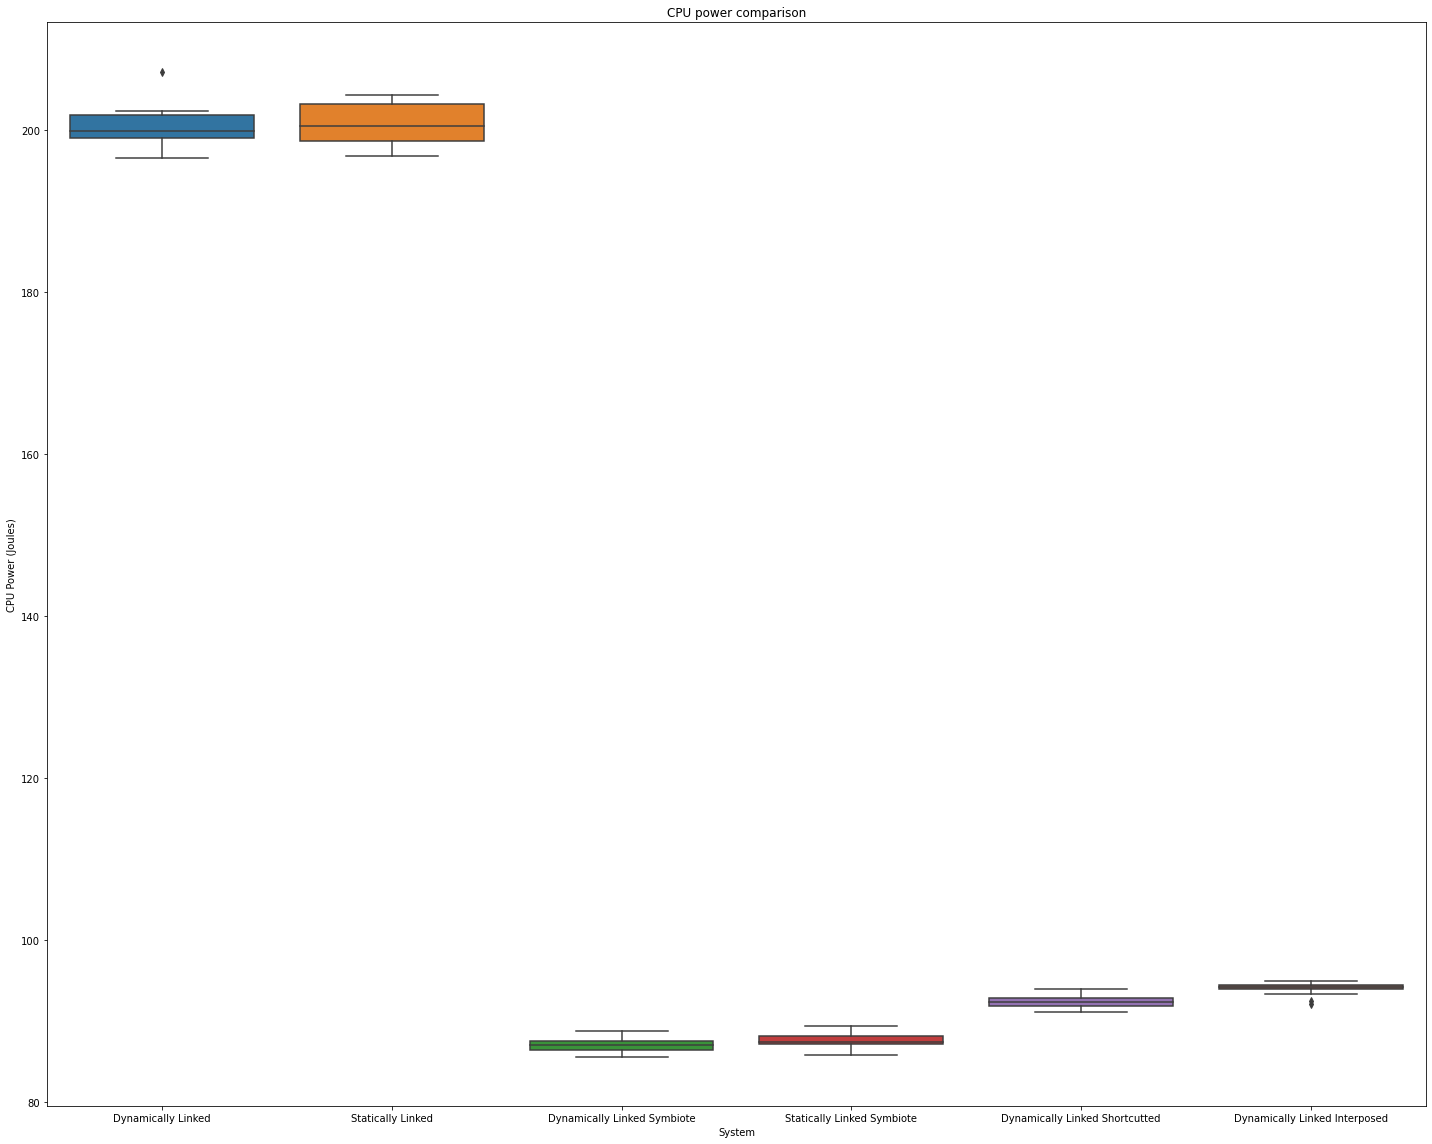

In [13]:
fig = sns.boxplot(y='Joules power/energy-cores/', x='sys', data=svd_cores_data_all)
fig.set(title="CPU power comparison")
plt.xlabel('System')
plt.ylabel('CPU Power (Joules)')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 16]
plt.savefig('graphs/power-cores.png')

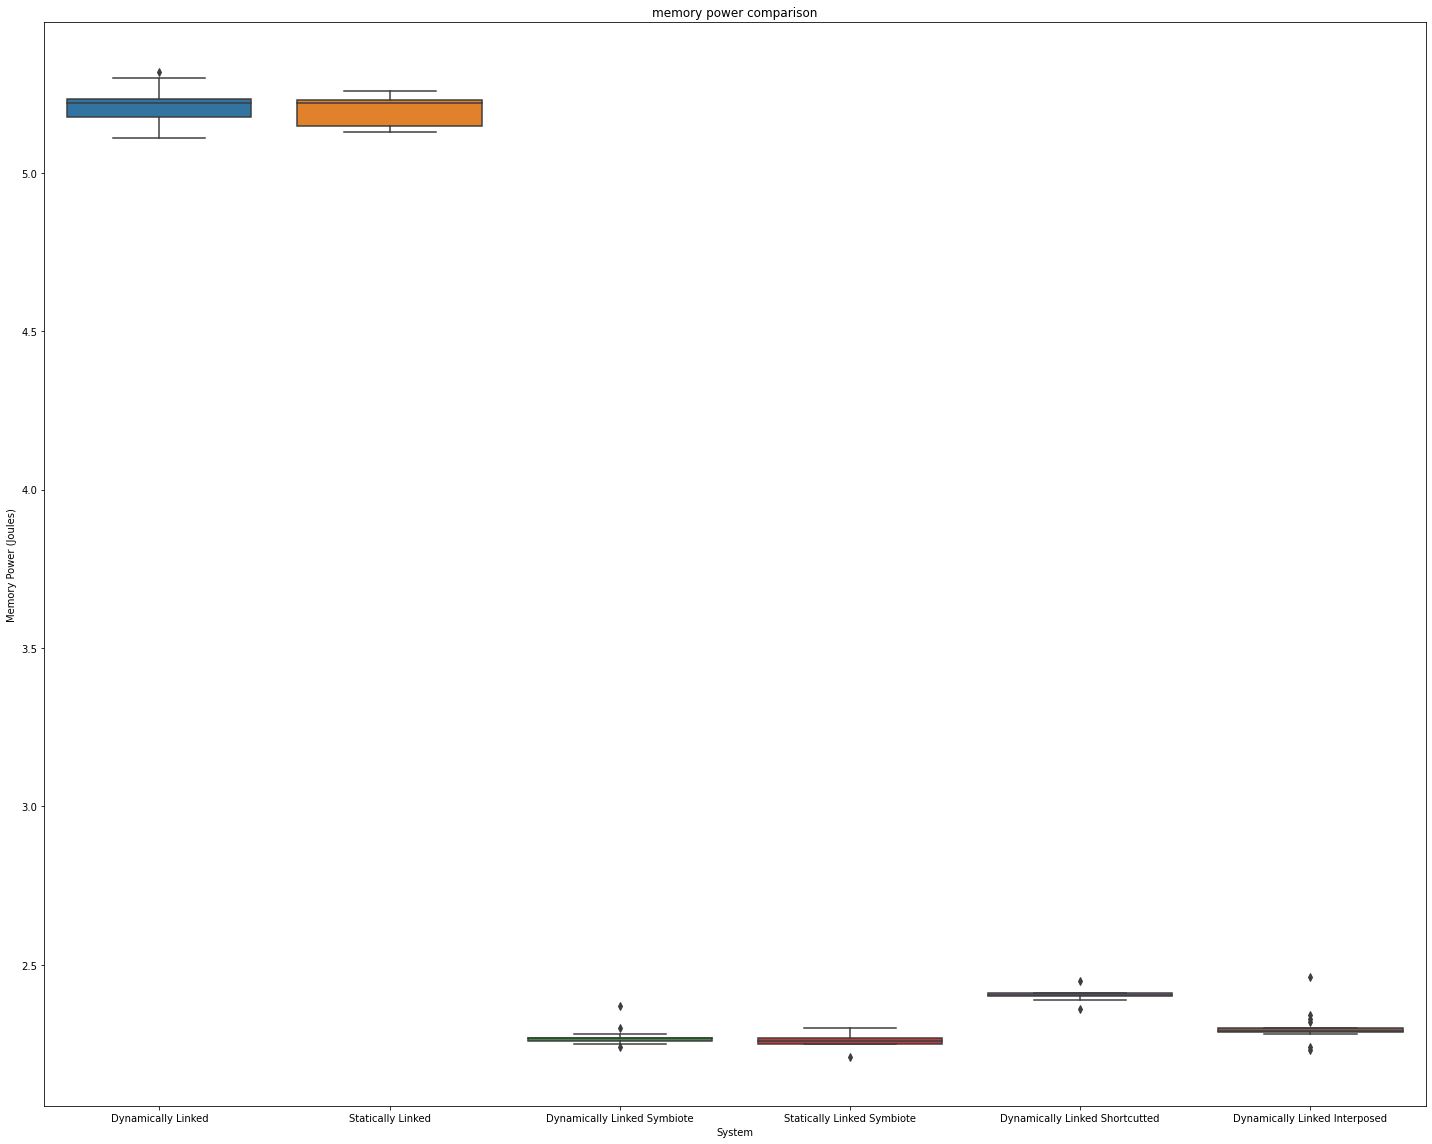

In [14]:
fig = sns.boxplot(y='Joules power/energy-ram/', x='sys', data=svd_mem_data_all)
fig.set(title="memory power comparison")
plt.xlabel('System')
plt.ylabel('Memory Power (Joules)')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 16]
plt.savefig('graphs/power-mem.png')